### Theory

Two of the most popular general
_Segmentation_ datasets are: [Microsoft COCO](http://mscoco.org/) and [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/).

image upsampling: get the prediction map
that is of the same size as an input image. 

We will do this using _transposed convolution_
(also known as __deconvolution or fractionally strided convolution__). 

> can be seen as __a way to perform interpolation__: Interpolation can be different (quadratic, qubic and other) but network can learn a specific
interpolation that performs well under a certain task.` 

Define the upsampling operation as a layer in the network.

> why do we need it as a layer? 

Because we will have to perform training where the image and
respective _Segmentation_ groundtruth will be given to us -- and we will have to perform
training using backpropagation.


As it is [known](http://www.robots.ox.ac.uk/~vgg/practicals/cnn/) , each layer in the network has to be able to perform three operations:

- _forward propagation_
- _backward propagation_ 
- _update_ 

which performs updates
to the weights of the layer during training. 

By doing the upsampling with _transposed convolution_
we will have all of these operations defined and we will be able to perform training.

### Goal

- implement the upsampling using _FCN-32_ _Segmentation_ network
- compare to the implementation of the [scikit-image library](http://scikit-image.org/).


In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt

# A place where you have downloaded a network checkpoint -- look at the previous post
checkpoints_dir = '/home/karen/Downloads/data/VGG_checkpoints'
sys.path.append("/home/karen/workspace/py/models/research/slim")

### Image Upsampling

_Image Upsampling_ is a specific case of _Resampling_.
According to a definition, provided in [this article about _Resampling_](http://avisynth.nl/index.php/Resampling):


```
The idea behind resampling is to reconstruct the continuous signal from the original sampled signal and resample it again using more samples (which is called interpolation or upsampling) or fewer samples (which is called decimation or downsampling)

```

In other words, we can approximate the continious signal from the points that
we have and sample new ones from the reconstructed signal. 

- downsample prediction map -- these are points from which we want to reconstruct original signal. 
- to approximate original signal, we can sample more points and, therefore, perform upsampling.

But what is the exact equation to get this reconstruction? Taking the equation from this [source](http://avisynth.nl/index.php/Resampling):

$$s(x) = sum_n s(n \cdot T) * sinc(\frac{x-n \cdot T}{T})$$ where $$sinc(x) = \frac{sin(pi*x)}{pi*x}$$

with $$fs = \frac{1}{T}$$ the sampling rate, $$s(n \cdot T)$$ the samples of s(x) and sinc(x) the resampling kernel.

[Wikipedia article](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) has a great explanation of the equation:


> A mathematically ideal way to interpolate the sequence involves the use of sinc functions. Each sample in the sequence is replaced by a sinc function, centered on the time axis at the original location of the sample, nT, with the amplitude of the sinc function scaled to the sample value, x[n]. Subsequently, the sinc functions are summed into a continuous function. A mathematically equivalent method is to convolve one sinc function with a series of Dirac delta pulses, weighted by the sample values. Neither method is numerically practical. Instead, some type of approximation of the sinc functions, finite in length, is used. The imperfections attributable to the approximation are known as interpolation error.


So, we can see that the continious signal is reconstructed ``by placing the resampling kernel
function at each point that we have and summing up everything``. 

It should be stated here that the resampling kernel shouldn't necessary
be sinc function. 

find more
examples [here](http://avisynth.nl/index.php/Resampling). 


Also, one important point
from the explanation above is that `athematically equivalent way is to convolve the
kernel function with series of Dirac delta pulses, weighted by the sample values` 

These
two equavalent ways to perform reconstruction are important as they will make understanding
of how transposed convolution work and that ``each transposed convolution has an equivalent
convolution.``

### First, implement image upsampling using built-in function from [scikit-image library](http://scikit-image.org/)

In [2]:
%matplotlib inline

from numpy import ogrid, repeat, newaxis

from skimage import io

imsize = 3 # 3x3 img size
x, y = ogrid[:imsize, :imsize]
print(x, y)

[[0]
 [1]
 [2]] [[0 1 2]]


In [3]:
print(x+y)

[[0 1 2]
 [1 2 3]
 [2 3 4]]


In [4]:
print(x*y)

[[0 0 0]
 [0 1 2]
 [0 2 4]]


In [5]:
print((x + y)[..., newaxis])

[[[0]
  [1]
  [2]]

 [[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]]


In [6]:
print(repeat((x + y)[..., newaxis], repeats=3, axis=2))

[[[0 0 0]
  [1 1 1]
  [2 2 2]]

 [[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[2 2 2]
  [3 3 3]
  [4 4 4]]]


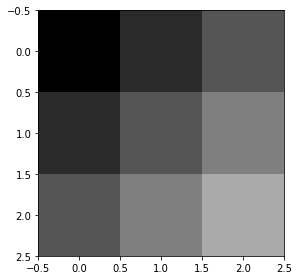

In [7]:
img = repeat((x + y)[..., newaxis], repeats=3, axis=2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

###  factor

The factor of upsampling is ``equal to the stride of transposed convolution``. 


The kernel of the upsampling
operation is determined by the identity: 

$$2 \cdot factor - factor\%2$$.

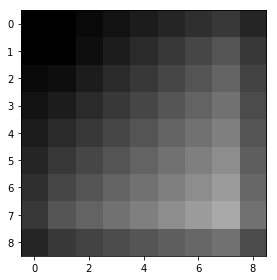

In [8]:
import skimage.transform

def upsample_skimage(factor, input_img):
    
    # padding = 0
    # order = 1 is bilinear upsampling
    # factor == stride of deconv
    return skimage.transform.rescale(input_img,
                                     factor,
                                     mode='constant',
                                     cval=0,
                                     order=1)


upsampled_img_skimage = upsample_skimage(factor=3, input_img=img)
io.imshow(upsampled_img_skimage, interpolation='none')

## Transposed convolution

First we look at a usual convolution and see that it convolves
the image and depending on the parameters (stride, kernel size, padding) reduces
the input image. What if we would be able to perform an operation that goes
in the `opposite direction -- from small input to the bigger one while preserving the
connectivity pattern`. 

![alt text](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_3/Deconv_exp.PNG)

Convolution is a linear operation and, therefore, it can be represented as a ``matrix
multiplication``.

To achieve the result described above, ``we only need to traspose the matrix that defines a particular convolution. The resulted operation is no longer a convolution, but it can still be represented as a convolution``, which won't be 
as efficient as transposing a convolution. 


To get more information about the equivalence
and transposed convolution in general we refer reader to [this paper](https://arxiv.org/pdf/1609.07009.pdf)
and [this guide](https://arxiv.org/pdf/1603.07285.pdf).


So, if we define a `bilinear upsampling kernel` and perform fractionally strided
convolution on the image, we will get an upsampled output, `which will be defined as a layer in the network and will make it possible for us to perform backpropagation.`


> For the FCN-32 we will use bilinear upsampling kernel as an initialization, meaning that
the network __can learn a more suitable kernel during backpropagation__


In [9]:
import numpy as np
import tensorflow as tf


def get_kernel_size(factor):
    return 2 * factor - factor % 2

def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1: 
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)


In [10]:
def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    #print("unsample_kernel:", upsample_kernel.shape, upsample_kernel)
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


In [11]:
def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    expanded_img = np.expand_dims(input_img, axis=0)

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor, number_of_classes)
                #print("upsample_filter_np", upsample_filter_np.shape, upsample_filter_np)

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                                 output_shape=[1, new_height, new_width, number_of_classes],
                                 strides=[1, factor, factor, 1])

                final_result = sess.run(res, feed_dict={upsample_filt_pl: upsample_filter_np,
                                                               logits_pl: expanded_img})
    
    return final_result.squeeze() # remove empty dimension


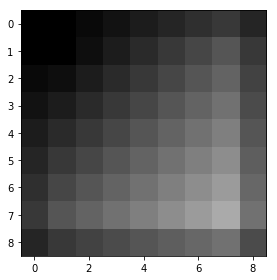

In [12]:
upsampled_img_tf = upsample_tf(factor=3, input_img=img)
io.imshow(upsampled_img_tf)

In [13]:
# Test if the results of upsampling are the same
np.allclose(upsampled_img_skimage, upsampled_img_tf)

True

In [14]:
for factor in range(2, 10):
    
    upsampled_img_skimage = upsample_skimage(factor=factor, input_img=img)
    upsampled_img_tf = upsample_tf(factor=factor, input_img=img)
   
    if np.allclose(upsampled_img_skimage, upsampled_img_tf):
        print("factor {} is checked out".format(factor)) 

factor 2 is checked out
factor 3 is checked out
factor 4 is checked out
factor 5 is checked out
factor 6 is checked out
factor 7 is checked out
factor 8 is checked out
factor 9 is checked out


### Upsampled predictions

### Now apply upsampling to the actual predictions.

take the _VGG-16_ model and apply our upsampling
to the downsampled predictions that we get from the network.


Before applying the code below we had to change a [certain line](https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/contrib/slim/python/slim/nets/vgg.py#L165)
in the definition of _VGG-16_ model to prevent it from reducing the size even more, so we should change the _7x7_ convolutional layer padding to _SAME_ option. In the case of segmentation
we don't need padding `because otherwise by upsampling by factor 32 we won't get
the image of the same size as the input`. 

#### Since we have huge filters _64 by 64_ and _1000_ classes. the code below and specifically the upsampling variable consumes a huge amount of space (~15 Gb). 

``Moreover, we actually don't use a lot of space of the upsampling variable,
because we define only the diagonal submatrices, therefore, a lot of space is wasted.``

In [15]:
import urllib
import tensorflow as tf
slim = tf.contrib.slim

from datasets import imagenet
from nets import vgg

In [18]:
def create_readable_names_for_imagenet_labels():
    """Create a dict mapping label id to human readable string.
            one synset one per line, eg:
              #   n01440764
              #   n01443537
            synset in Imagenet, eg:
              #   n02119247    black fox
              #   n02119359    silver fox
      
      Code is based on
      https://github.com/tensorflow/models/blob/master/research/inception/inception/data/build_imagenet_data.py#L463
    """
    base_url = 'https://raw.githubusercontent.com/tensorflow/serving/master/tensorflow_serving/example'
    synset_url = '{}/imagenet_lsvrc_2015_synsets.txt'.format(base_url)
    synset_to_human_url = '{}/imagenet_metadata.txt'.format(base_url)

    filename, _ = urllib.request.urlretrieve(synset_url)
    synset_list = [s.strip() for s in open(filename).readlines()]
    num_synsets_in_ilsvrc = len(synset_list)
    assert num_synsets_in_ilsvrc == 1000

    filename, _ = urllib.request.urlretrieve(synset_to_human_url)
    synset_to_human_list = open(filename).readlines()
    num_synsets_in_all_imagenet = len(synset_to_human_list)
    assert num_synsets_in_all_imagenet == 21842

    synset_to_human = {}
    for s in synset_to_human_list:
        parts = s.strip().split('\t')
        assert len(parts) == 2
        synset = parts[0]
        human = parts[1]
        synset_to_human[synset] = human

    label_index = 1
    labels_to_names = {0: 'background'}
    for synset in synset_list:
        name = synset_to_human[synset]
        labels_to_names[label_index] = name
        label_index += 1

    return labels_to_names

In [16]:
# print segmentation results with
# colorbar showing class names
def discrete_matshow(data, labels_names=[], title=""):
    #get discrete colormap
    cmap = plt.get_cmap('Paired', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,
                      cmap=cmap,
                      vmin = np.min(data)-.5,
                      vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat,
                       ticks=np.arange(np.min(data),np.max(data)+1))
    
    # The names to be printed aside the colorbar
    if labels_names:
        cax.ax.set_yticklabels(labels_names)
    
    if title:
        plt.suptitle(title, fontsize=14, fontweight='bold')


INFO:tensorflow:Restoring parameters from /home/karen/Downloads/data/VGG_checkpoints/vgg_16.ckpt


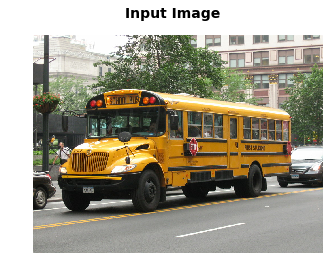

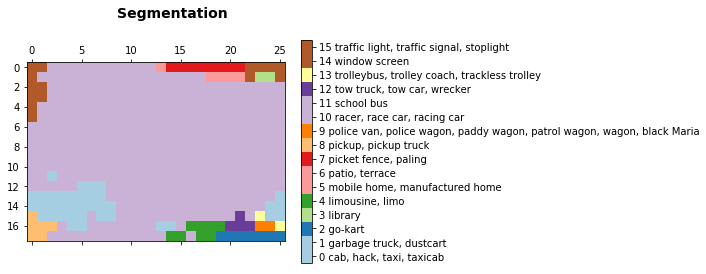

In [ ]:
from preprocessing import vgg_preprocessing

from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

with tf.Graph().as_default():
    
    url = ("https://upload.wikimedia.org/wikipedia/commons/d/d9/"
           "First_Student_IC_school_bus_202076.jpg")
    
    image_string = urllib.request.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # Convert image to float32 before subtracting the
    # mean pixel value
    image_float = tf.to_float(image)
    
    # Subtract the mean pixel value from each pixel
    processed_image = _mean_image_subtraction(image_float,
                                              [_R_MEAN, _G_MEAN, _B_MEAN])

    input_image = tf.expand_dims(processed_image, 0)
    
    with slim.arg_scope(vgg.vgg_arg_scope()):
        
        # spatial_squeeze option enables to use network in a fully
        # convolutional manner
        logits, _ = vgg.vgg_16(input_image,
                               num_classes=1000,
                               is_training=False,
                               spatial_squeeze=False)
    
    # For each pixel we get predictions for each class
    # out of 1000. We need to pick the one with the highest
    # probability
    
    # But these are not probabilities,
    # because we didn't apply softmax. But if we pick a class
    # with the highest value it will be equivalent to picking
    # the highest value after applying softmax
    pred = tf.argmax(logits, dimension=3)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        segmentation, np_image, np_logits = sess.run([pred, image, logits])

# Remove the first empty dimension
segmentation = np.squeeze(segmentation)

# Let's get unique predicted classes (from 0 to 1000) and
# relable the original predictions so that classes are
# numerated starting from zero
unique_classes, relabeled_image = np.unique(segmentation,
                                            return_inverse=True)

segmentation_size = segmentation.shape

relabeled_image = relabeled_image.reshape(segmentation_size)

labels_names = []


names = create_readable_names_for_imagenet_labels()
for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")



In [ ]:
upsampled_logits = upsample_tf(factor=32, input_img=np_logits.squeeze())
upsampled_predictions = upsampled_logits.squeeze().argmax(axis=2)

unique_classes, relabeled_image = np.unique(upsampled_predictions,
                                            return_inverse=True)

relabeled_image = relabeled_image.reshape(upsampled_predictions.shape)

labels_names = []

for index, current_class_number in enumerate(unique_classes):

    labels_names.append(str(index) + ' ' + names[current_class_number+1])

# Show the downloaded image
plt.figure()
plt.imshow(np_image.astype(np.uint8))
plt.suptitle("Input Image", fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

discrete_matshow(data=relabeled_image, labels_names=labels_names, title="Segmentation")